In [1]:
!pip install wordcloud -q
!pip install spacy
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 77.4 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [1]:
import spacy
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from wordcloud import WordCloud
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
from collections import Counter
from scipy.spatial.distance import pdist, squareform
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from sklearn.manifold import TSNE


# 1. Cleaning data and preprocessing

In [2]:
from create_dataframe import prepare_legislatives_dataset

csv_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981.csv"
txt_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981"

df_final = prepare_legislatives_dataset(csv_p, txt_p)

With this code, we will do:
1. **OCR artifact cleaning:** remove line breaks, special characters, and isolated small numbers.
2. **Text normalization:** convert text to lowercase, remove unnecessary punctuation.
3. **Tokenization and filtering:** remove stopwords, punctuation, and whitespace tokens.
4. **Lemmatization:** reduce words to their base form.
5. **Filter rare words**

These operations reduce noise, standardize the text, and retain only meaningful lexical information, thereby improving the robustness and interpretability of subsequent NLP models.

In [3]:
############# Load the French language model ############

nlp = spacy.load("fr_core_news_sm")

# We include additional stopwords that are specific to our corpus
custom_stops = ["candidat", "suppléant", "circonscription", "cest"]
for word in custom_stops:
    nlp.vocab[word].is_stop = True

In [4]:
############# functions to clean data ############

def preprocess_text(text, use_lemma=True):
    """Full preprocessing: OCR cleaning + tokenization + stopwords removal + lemmatization."""
    
    # --- OCR cleaning ---
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'[^\w\s\.,;!?]', '', text)
    text = re.sub(r'\b\d{1,2}\b', '', text)
    
    # --- Lowercase + spaCy processing ---
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and token.is_alpha and len(token) > 2:
            tokens.append(token.lemma_ if use_lemma else token.text)
    
    return " ".join(tokens)


def filter_rare_words(corpus, min_docs=5):
    """
    Filter out words appearing in fewer than min_docs documents.
    
    Parameters:
        corpus : List of preprocessed text strings.
        min_docs : Minimum number of documents a word must appear in to be kept.
            
    Returns:
        filtered_corpus : Corpus with rare words removed.
    """
    # Compute document frequency
    doc_freq = Counter()
    for text in corpus:
        for word in set(text.split()):
            doc_freq[word] += 1

    # Keep words appearing in at least min_docs documents
    vocab = {word for word, freq in doc_freq.items() if freq >= min_docs}

    # Filter each document
    filtered_corpus = [" ".join([word for word in text.split() if word in vocab])
                       for text in corpus]
    
    return filtered_corpus

# Execution
print("Starting text cleaning with spaCy (this may take 1–2 minutes)...")
df_final["clean_text"] = df_final["text_content"].apply(preprocess_text)
df_final["clean_text_filtered"] = filter_rare_words(df_final["clean_text"], min_docs=5)
print("Text cleaning completed")




Starting text cleaning with spaCy (this may take 1–2 minutes)...


Text cleaning completed


## 1.2 Wordclouds for each category

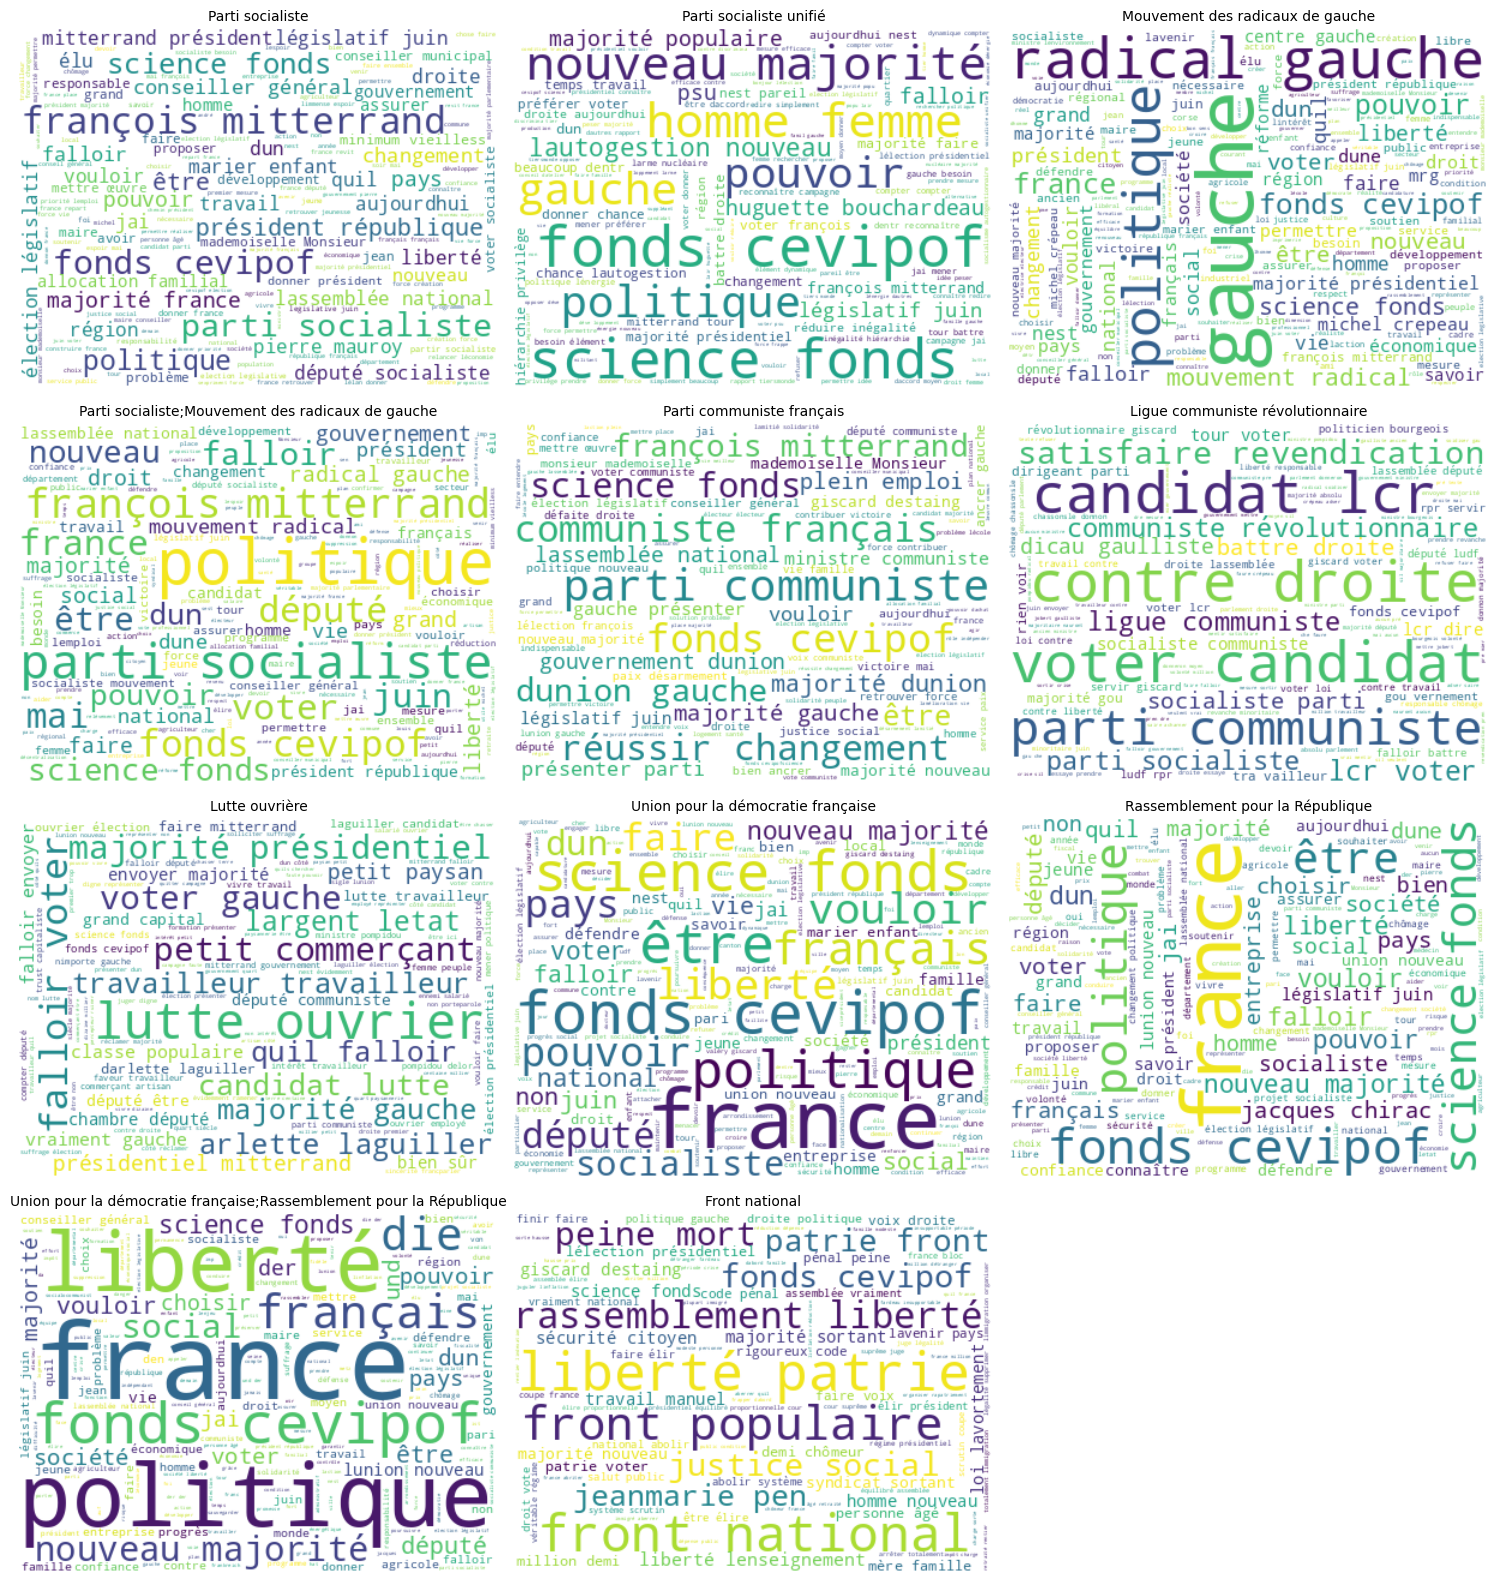

In [16]:

# List of categories in a specific order
categories = [
    "Parti socialiste", "Parti socialiste unifié",
    "Mouvement des radicaux de gauche", "Parti socialiste;Mouvement des radicaux de gauche",
    "Parti communiste français", "Ligue communiste révolutionnaire", "Lutte ouvrière",
    "Union pour la démocratie française", "Rassemblement pour la République",
    "Union pour la démocratie française;Rassemblement pour la République", "Front national"
]

# Number of columns for display and automatically computation of the number of rows
n_cols = 3
n_rows = (len(categories) + n_cols - 1) // n_cols  


# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  

# Loop over categories and generate WordClouds
for i, cat in enumerate(categories):
    # Merge all preprocessed texts for the current category
    text_cat = " ".join(df_final[df_final['titulaire-soutien'] == cat]['clean_text_filtered'].astype(str))
    
    if text_cat.strip():  
        # Generate Wordcloud
        wc = WordCloud(
            width=400,
            height=300,
            background_color='white',
            colormap='viridis'
        ).generate(text_cat)
        
        # Display the WordCloud in the subplot
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(cat, fontsize=10)
    else:
        axes[i].axis('off')
        axes[i].set_title(f"{cat} (no data)", fontsize=10)


# Remove unused axes if the number of categories is not a multiple of n_cols
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# 2. Regression logistic's implementation (first test without fusioning or deleting categories)

We first define a function to implement the logistic regression as we will implemente the model two times.

As we have some categories with a small number of manifestos, we will use stratified cross-validation and hyperparameter tuning.
Since the categories are imbalanced, we will use `class_weight='balanced'` to give more importance to minority classes and  maximize F1 score.

In [7]:
# To apply this function, we need to clean data (section 1.1) before

def logistic_regression_nlp(df, text_col="vlean_text_filtered", label_col="titulaire-soutien", min_docs=5, cv_folds=5, random_state=42):
    """
    Performs logistic regression on NLP text data with TF-IDF features using Stratified CV.

    Parameters:
        df : DataFrame containing text and labels
        min_docs : Minimum number of documents a word must appear in
        cv_folds : Number of folds for StratifiedKFold
        random_state : Random state for reproducibility

    Returns:
        best_model : trained Pipeline with the best hyperparameters and confusion matrice
    """

    X = df["clean_text_filtered"].astype(str)
    y = df[label_col].astype(str)

    # Pipeline
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("lr", LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])

    # Hyperparameter grid
    param_grid = {
        'tfidf__max_features': [1000, 3000, 5000],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'lr__C': [0.1, 1.0, 10.0]
    }

    # GridSearch 
    #    # StratifiedKFold → conserve the proportion of each class in each fold
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    grid = GridSearchCV(pipe, param_grid, scoring='f1_weighted', cv=cv, n_jobs=-1, verbose=1)
    grid.fit(X, y)

    best_model = grid.best_estimator_
    print(f"✅ Best hyperparameters: {grid.best_params_}, F1 (CV): {grid.best_score_:.4f}")

    # Cross-val predictions pour classification report et confusion matrix
    y_pred = cross_val_predict(best_model, X, y, cv=cv)
    print("\n--- CLASSIFICATION REPORT (CV) ---")
    print(classification_report(y, y_pred))

    fig, ax = plt.subplots(figsize=(15,10))
    ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    plt.title("Confusion Matrix (CV)")
    plt.tight_layout()
    plt.show()

    return best_model


Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ Best hyperparameters: {'lr__C': 1.0, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}, F1 (CV): 0.8979

--- CLASSIFICATION REPORT (CV) ---
                                                                     precision    recall  f1-score   support

                                                     Front national       1.00      0.98      0.99        44
                                   Ligue communiste révolutionnaire       1.00      1.00      1.00        32
                                                     Lutte ouvrière       1.00      0.99      1.00       159
                                   Mouvement des radicaux de gauche       1.00      0.89      0.94        46
                                          Parti communiste français       1.00      0.99      0.99       463
                                                   Parti socialiste       0.95      0.97      0.96       407
                        

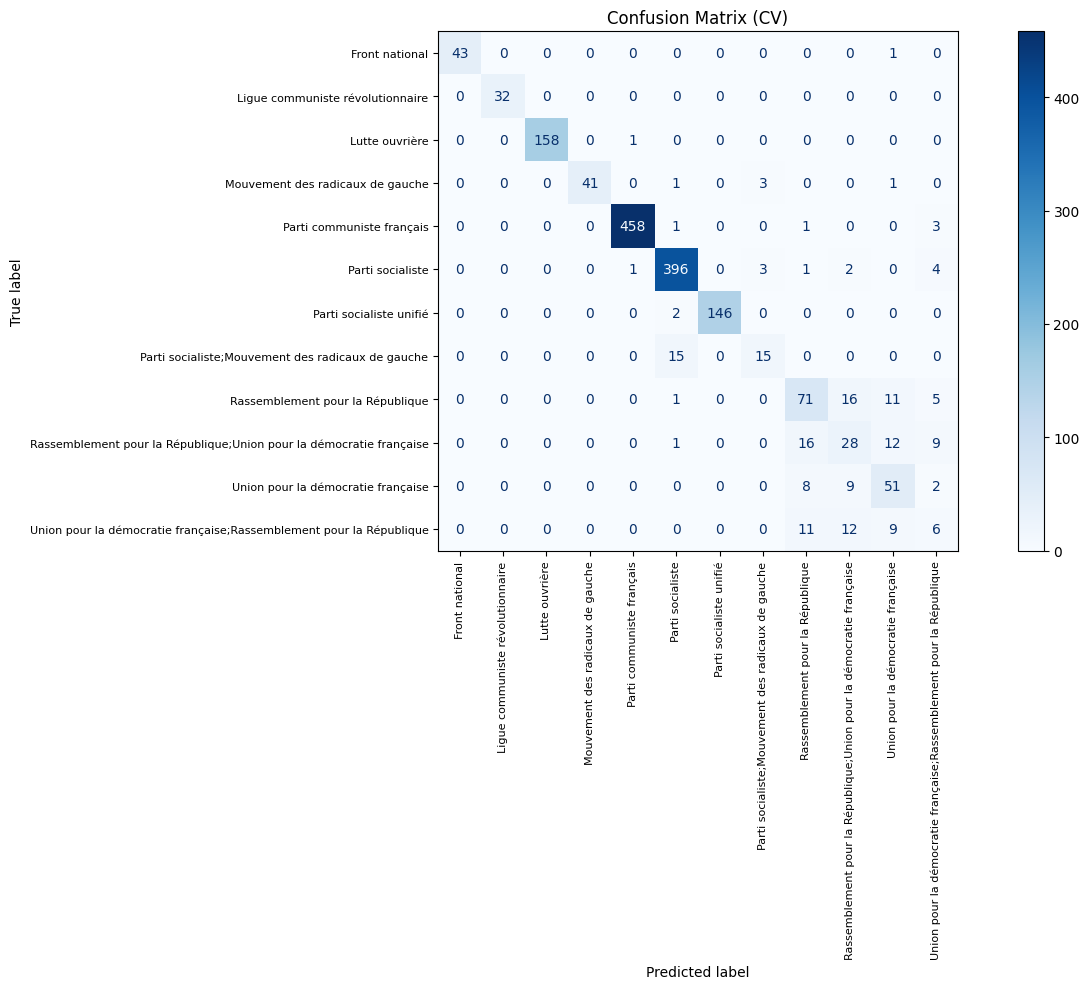

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [9]:
# Implementation of the logistic regression
logistic_regression_nlp(df_final, text_col="clean_text_filtered", label_col="titulaire-soutien", min_docs=5,  cv_folds=5, random_state=42)

# 3. Logistic regression (after deleting the bi-support categories)

## 3.1 Model implementation

Fitting 5 folds for each of 18 candidates, totalling 90 fits


✅ Best hyperparameters: {'lr__C': 0.1, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}, F1 (CV): 0.9736

--- CLASSIFICATION REPORT (CV) ---
                                    precision    recall  f1-score   support

                    Front national       1.00      0.98      0.99        44
  Ligue communiste révolutionnaire       1.00      1.00      1.00        32
                    Lutte ouvrière       1.00      1.00      1.00       159
  Mouvement des radicaux de gauche       1.00      0.93      0.97        46
         Parti communiste français       1.00      0.99      1.00       463
                  Parti socialiste       0.98      0.99      0.99       407
           Parti socialiste unifié       1.00      0.99      0.99       148
  Rassemblement pour la République       0.86      0.85      0.85       104
Union pour la démocratie française       0.79      0.84      0.81        70

                          accuracy                           0.97      1473
           

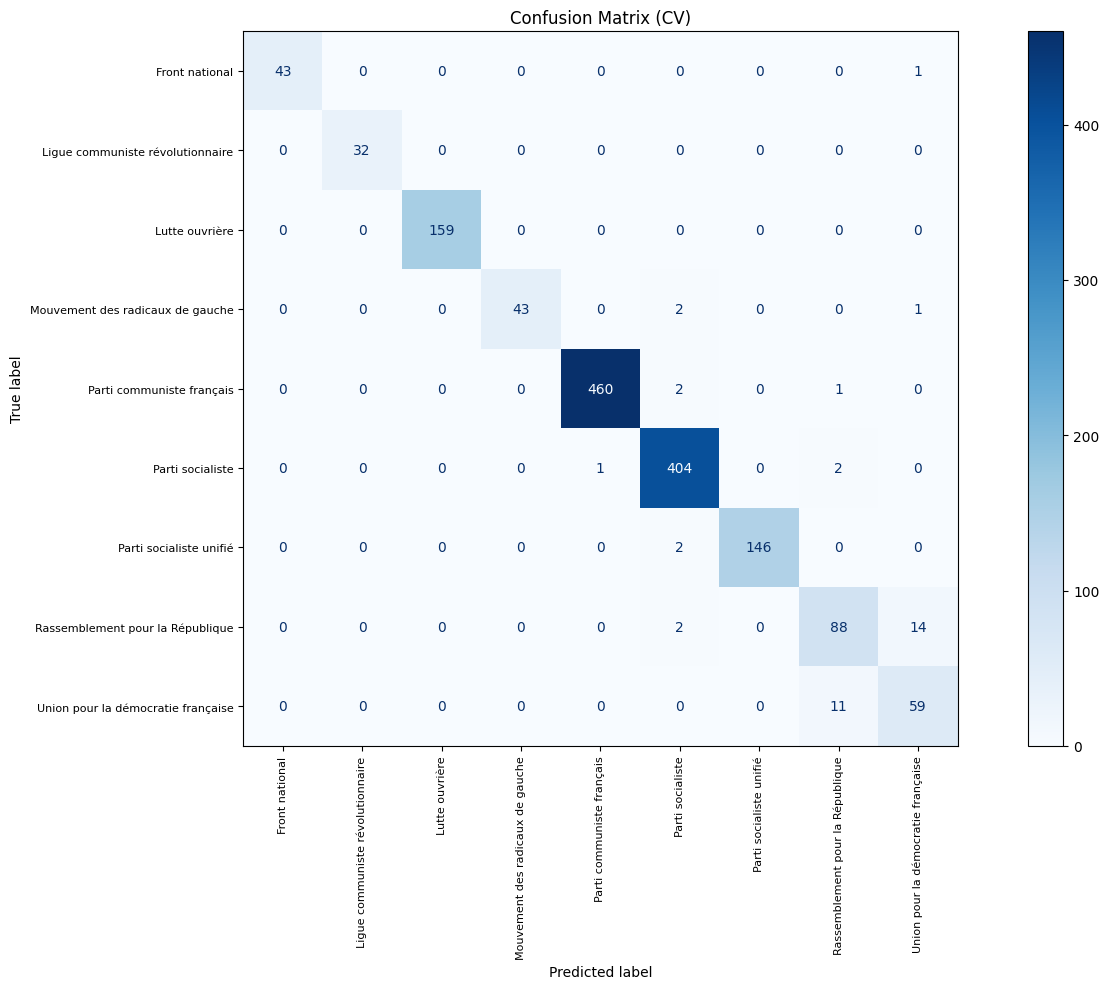

In [10]:
# Deleting the bi-support categories
categories_a_supprimer = ['Parti socialiste;Mouvement des radicaux de gauche', 'Rassemblement pour la République;Union pour la démocratie française',  'Union pour la démocratie française;Rassemblement pour la République']
df_final_sans_cat_mixte = df_final[~df_final['titulaire-soutien'].isin(categories_a_supprimer)]

# Implementation of the logistic regression
best_model =logistic_regression_nlp(df_final_sans_cat_mixte, text_col="clean_text_filtered", label_col="titulaire-soutien", min_docs=5,  cv_folds=5, random_state=42)

## 3.2 Coefficients' interpretation

In [14]:
# This block builds formatted tables of the most discriminant words 
# (largest absolute logistic regression coefficients) for each party 
# and displays them in grouped, color-coded layouts.

def build_party_table_abs(cat, top_n=10):
    """
    Build a table of the top |coef| features for a given party.

    Input: party/class name.

    Output: table with top_n features and their coefficients.
    """
    df_class = coef_df[coef_df['class'] == cat].copy()
    
    # Rank features by absolute coefficient magnitude
    df_class["abs_coef"] = df_class["coef"].abs()
    top_abs = df_class.sort_values("abs_coef", ascending=False).head(top_n)
    
    table = top_abs[["feature", "coef"]].reset_index(drop=True)
    table.columns = [f"{cat} - mot", f"{cat} - coef"]
    
    return table


def color_coef(val):
    """
    Assign color styling based on coefficient sign.

    Input: logistic regression coefficient.

    Output: CSS style (blue for positive, red for negative).
    """
    if val > 0:
        return "color: #1f77b4; font-weight: bold;"  # blue
    elif val < 0:
        return "color: #d62728; font-weight: bold;"  # red
    else:
        return ""


def display_three_parties_abs(categories, n_cols=3, top_n=10):
    """
    Display styled tables of top |coef| features for parties,
    grouped by rows of n_cols parties.

    Input: 
        categories: list of party names.
        n_cols: number of parties displayed per row.

    Output: None
    """
    for i in range(0, len(categories), n_cols):
        block = categories[i:i+n_cols]
        
        tables = [build_party_table_abs(cat, top_n=top_n) for cat in block]
        combined = pd.concat(tables, axis=1)
        
        coef_cols = [col for col in combined.columns if "coef" in col]
        
        styled = combined.style.applymap(color_coef, subset=coef_cols)
        display(styled)


In [18]:
import pandas as pd
import numpy as np

# Récupérer les coefficients
lr = best_model.named_steps["lr"]
vectorizer = best_model.named_steps["tfidf"]

feature_names = vectorizer.get_feature_names_out()
coefs = lr.coef_

classes = lr.classes_

rows = []

for i, class_label in enumerate(classes):
    for feature, coef in zip(feature_names, coefs[i]):
        rows.append({
            "class": class_label,
            "feature": feature,
            "coef": coef
        })

coef_df = pd.DataFrame(rows)


In [19]:
display_three_parties_abs(categories)


/tmp/ipykernel_216270/3523363331.py:60: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = combined.style.applymap(color_coef, subset=coef_cols)


,Parti socialiste - mot,Parti socialiste - coef,Parti socialiste unifié - mot,Parti socialiste unifié - coef,Mouvement des radicaux de gauche - mot,Mouvement des radicaux de gauche - coef
0,socialiste,0.825743,psu,0.915120,radical,1.505666
1,parti socialiste,0.634459,nucléaire,0.715608,radical gauche,1.501416
2,président,0.499232,lautogestion,0.695401,mouvement radical,1.046588
3,gauche,-0.495413,autogestionnaire,0.495308,gauche,0.856197
4,françois mitterrand,0.486182,populaire,0.469340,michel,0.625558
5,communiste,-0.474356,femme,0.410770,mrg,0.587982
6,françois,0.458488,alternative,0.395890,mouvement,0.544926
7,france,0.430993,bouchardeau,0.389071,michel crepeau,0.530977
8,majorité france,0.381376,hiérarchie,0.388738,crepeau,0.530977
9,mitterrand,0.362701,majorité populaire,0.386947,centre gauche,0.441957


/tmp/ipykernel_216270/3523363331.py:60: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = combined.style.applymap(color_coef, subset=coef_cols)


,Parti socialiste;Mouvement des radicaux de gauche - mot,Parti socialiste;Mouvement des radicaux de gauche - coef,Parti communiste français - mot,Parti communiste français - coef,Ligue communiste révolutionnaire - mot,Ligue communiste révolutionnaire - coef
0,nan,nan,communiste,1.332198,lcr,0.798989
1,nan,nan,dunion,0.621021,candidat lcr,0.526635
2,nan,nan,réussir,0.607222,lunité,0.519616
3,nan,nan,gauche,0.556299,patron,0.469339
4,nan,nan,changement,0.521436,contre,0.390651
5,nan,nan,communiste français,0.487662,satisfaire revendication,0.366191
6,nan,nan,parti communiste,0.477603,voie,0.362028
7,nan,nan,réussir changement,0.463881,droite,0.360905
8,nan,nan,dunion gauche,0.407414,revendication,0.355174
9,nan,nan,victoire,0.388602,voter candidat,0.350079


/tmp/ipykernel_216270/3523363331.py:60: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = combined.style.applymap(color_coef, subset=coef_cols)


,Lutte ouvrière - mot,Lutte ouvrière - coef,Union pour la démocratie française - mot,Union pour la démocratie française - coef,Rassemblement pour la République - mot,Rassemblement pour la République - coef
0,lutte ouvrier,0.810598,gauche,-0.565680,jacques chirac,0.684902
1,ouvrier,0.712609,union,0.454790,jacques,0.550535
2,lutte,0.665049,union nouveau,0.388061,gauche,-0.520317
3,travailleur,0.622192,excès,0.350740,société,0.422027
4,laguiller,0.493262,enfant,0.314624,chirac,0.399972
5,mitterrand,0.439255,france,0.302714,liberté,0.339681
6,falloir voter,0.413458,udf,0.302356,union nouveau,0.327079
7,chambre,0.407315,démocrate,0.296302,radical,-0.321702
8,trop,0.406326,radical gauche,-0.276108,nouveau majorité,0.284202
9,gauche,0.385010,droite,-0.259057,oui,0.280969


/tmp/ipykernel_216270/3523363331.py:60: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = combined.style.applymap(color_coef, subset=coef_cols)


,Union pour la démocratie française;Rassemblement pour la République - mot,Union pour la démocratie française;Rassemblement pour la République - coef,Front national - mot,Front national - coef
0,nan,nan,front,0.974027
1,nan,nan,patrie,0.862725
2,nan,nan,front national,0.728634
3,nan,nan,liberté patrie,0.612704
4,nan,nan,rassemblement,0.498150
5,nan,nan,national,0.475219
6,nan,nan,pen,0.454076
7,nan,nan,jeanmarie pen,0.451355
8,nan,nan,rassemblement liberté,0.441721
9,nan,nan,jeanmarie,0.408038


# 4. Projection et indice de dissimilarité

## 4.1 Indice de dissmiliraté entre les partis

The coefficients estimated by the logistic regression allow us to construct a dissimilarity index between parties. This index enables us to identify parties that are semantically closest to each other or, conversely, the most distant.

In [23]:
###############Build a coefficient matrix for all parties () Rows = parties, Columns = features) ##########################

# Pivot pour obtenir une matrice classes × features
coef_matrix_df = coef_df.pivot(
    index="class",
    columns="feature",
    values="coef"
).fillna(0)

# Convertir directement en numpy array
coef_matrix = coef_matrix_df.values



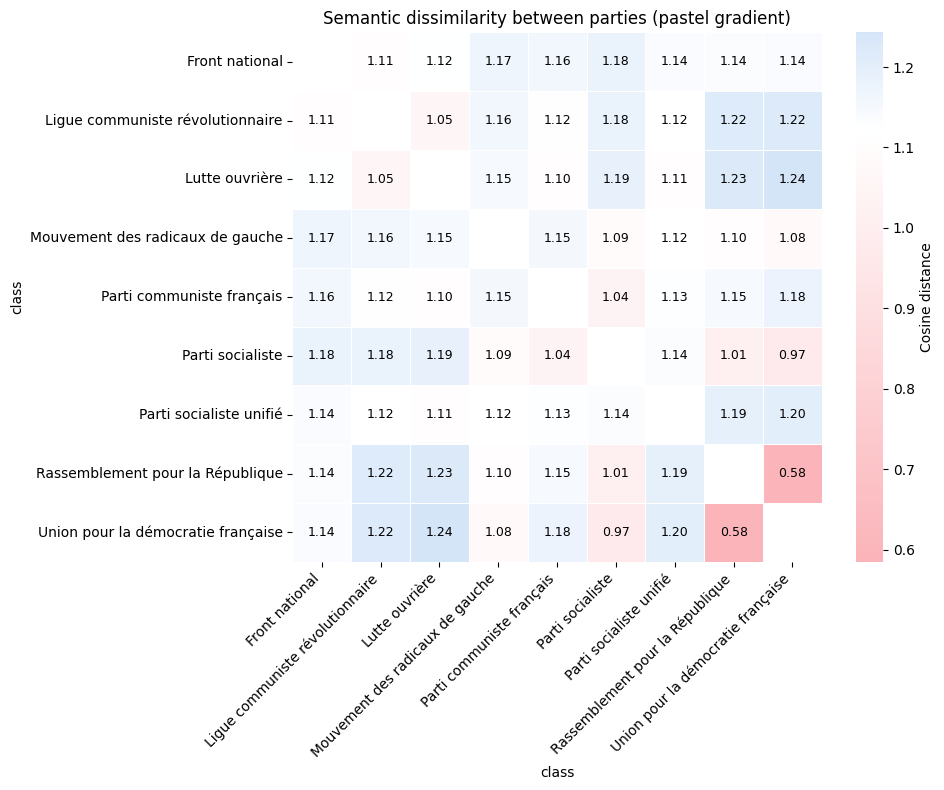

In [29]:
from sklearn.metrics.pairwise import cosine_distances

############ Plot a heatmap of semantic dissimilarity between parties using a smooth pastel gradient #####

# Compute the cosine distance matrix between parties
dist_df_cos = pd.DataFrame(
    cosine_distances(coef_matrix),
    index=coef_matrix_df.index,
    columns=coef_matrix_df.index
)

dist_plot = dist_df_cos.copy()

# Set diagonal to NaN so it appears white in the heatmap
np.fill_diagonal(dist_plot.values, np.nan)

plt.figure(figsize=(10, 8))

# Define a soft pastel gradient: pale pink -> white -> light blue
colors = ["#fbb4b9", "white", "#4a90e2"]  # bleu plus saturé
cmap = LinearSegmentedColormap.from_list("pastel_gradient", colors)

# Plot heatmap with annotations and pastel colors
sns.heatmap(
    dist_plot,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    center=dist_plot.mean().mean(),
    linewidths=0.5,
    cbar_kws={'label': 'Cosine distance'},
    square=True,
    annot_kws={"color": "black", "fontsize": 9}  # texte noir
)



# Adjust labels and layout
plt.title("Semantic dissimilarity between parties (pastel gradient)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [50]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# 1️⃣ Récupérer les features depuis le pipeline logistique
# TF-IDF
X = best_model.named_steps['tfidf'].transform(df_final['clean_text_filtered']).toarray()

# 2️⃣ Identifier les pôles uniques
poles = df_final['titulaire-soutien'].unique()
resultats_sim = []

for p in poles:
    # Vecteurs du pôle source
    mask_a = df_final['titulaire-soutien'] == p
    vecteurs_a = X[mask_a]
    
    # --- SIMILARITÉ INTRA-PARTI ---
    sim_intra = cosine_similarity(vecteurs_a)
    mask_tri = np.triu_indices(sim_intra.shape[0], k=1)  # ignore diagonale
    moyenne_intra = sim_intra[mask_tri].mean()
    
    # Ajouter la mesure Intra au tableau
    resultats_sim.append({
        'Pôle Source': p,
        'Pôle Cible': p,
        'Type': 'Intra (Cohésion)',
        'Similarité Moyenne': moyenne_intra
    })
    
    # --- SIMILARITÉ INTER-PARTIS ---
    for p_target in poles:
        if p != p_target:
            mask_b = df_final['titulaire-soutien'] == p_target
            vecteurs_b = X[mask_b]
            
            sim_inter = cosine_similarity(vecteurs_a, vecteurs_b)
            moyenne_inter = sim_inter.mean()
            
            resultats_sim.append({
                'Pôle Source': p,
                'Pôle Cible': p_target,
                'Type': 'Inter',
                'Similarité Moyenne': moyenne_inter
            })

# 3️⃣ DataFrame final avec toutes les similarités
df_sim_final = pd.DataFrame(resultats_sim)

# 4️⃣ Vérification
print(df_sim_final.head())


               Pôle Source                                         Pôle Cible  \
0  Parti socialiste unifié                            Parti socialiste unifié   
1  Parti socialiste unifié                          Parti communiste français   
2  Parti socialiste unifié  Parti socialiste;Mouvement des radicaux de gauche   
3  Parti socialiste unifié  Rassemblement pour la République;Union pour la...   
4  Parti socialiste unifié                                   Parti socialiste   

               Type  Similarité Moyenne  
0  Intra (Cohésion)            0.268149  
1             Inter            0.096399  
2             Inter            0.100438  
3             Inter            0.086051  
4             Inter            0.087634  


. Comment interpréter ce tableau ?
Score proche de 1 : Les deux pôles utilisent quasiment le même vocabulaire et les mêmes structures de phrases (ex: PS et PCF en 1981).

Score plus faible : Indique une rupture lexicale. Par exemple, si l'Extrême Droite a une similarité faible avec tous les autres, cela prouve qu'elle introduisait des thématiques (ou un ton) totalement absentes du "consensus" de l'époque.

Souhaitez-vous que j'ajoute à ce code une fonction pour identifie

Comment interpréter vos résultats pour 1981 ?
Si l'Intra-parti est élevé (ex: PCF ou Extrême Gauche) : Cela démontre une langue de bois ou une idéologie très codifiée. Les candidats reprennent mot pour mot les consignes nationales.

Si l'Intra-parti est faible (ex: Bloc de Droite ou de Gauche) : Cela montre une diversité de courants ou une forte adaptation locale des discours. Les candidats "brodent" autour du programme.

Si l'Inter-parti PS / RPR est élevé : Cela prouve que le clivage se joue sur des nuances ou des valeurs, mais que le socle de gestion (les sujets abordés : chômage, prix, sécurité) est identique.

Comparaison des blocs : Regardez si la similarité PS -> PCF est plus forte que RPR -> UDF. Cela vous dira quel camp était le plus uni sémantiquement lors de cette élection historique.



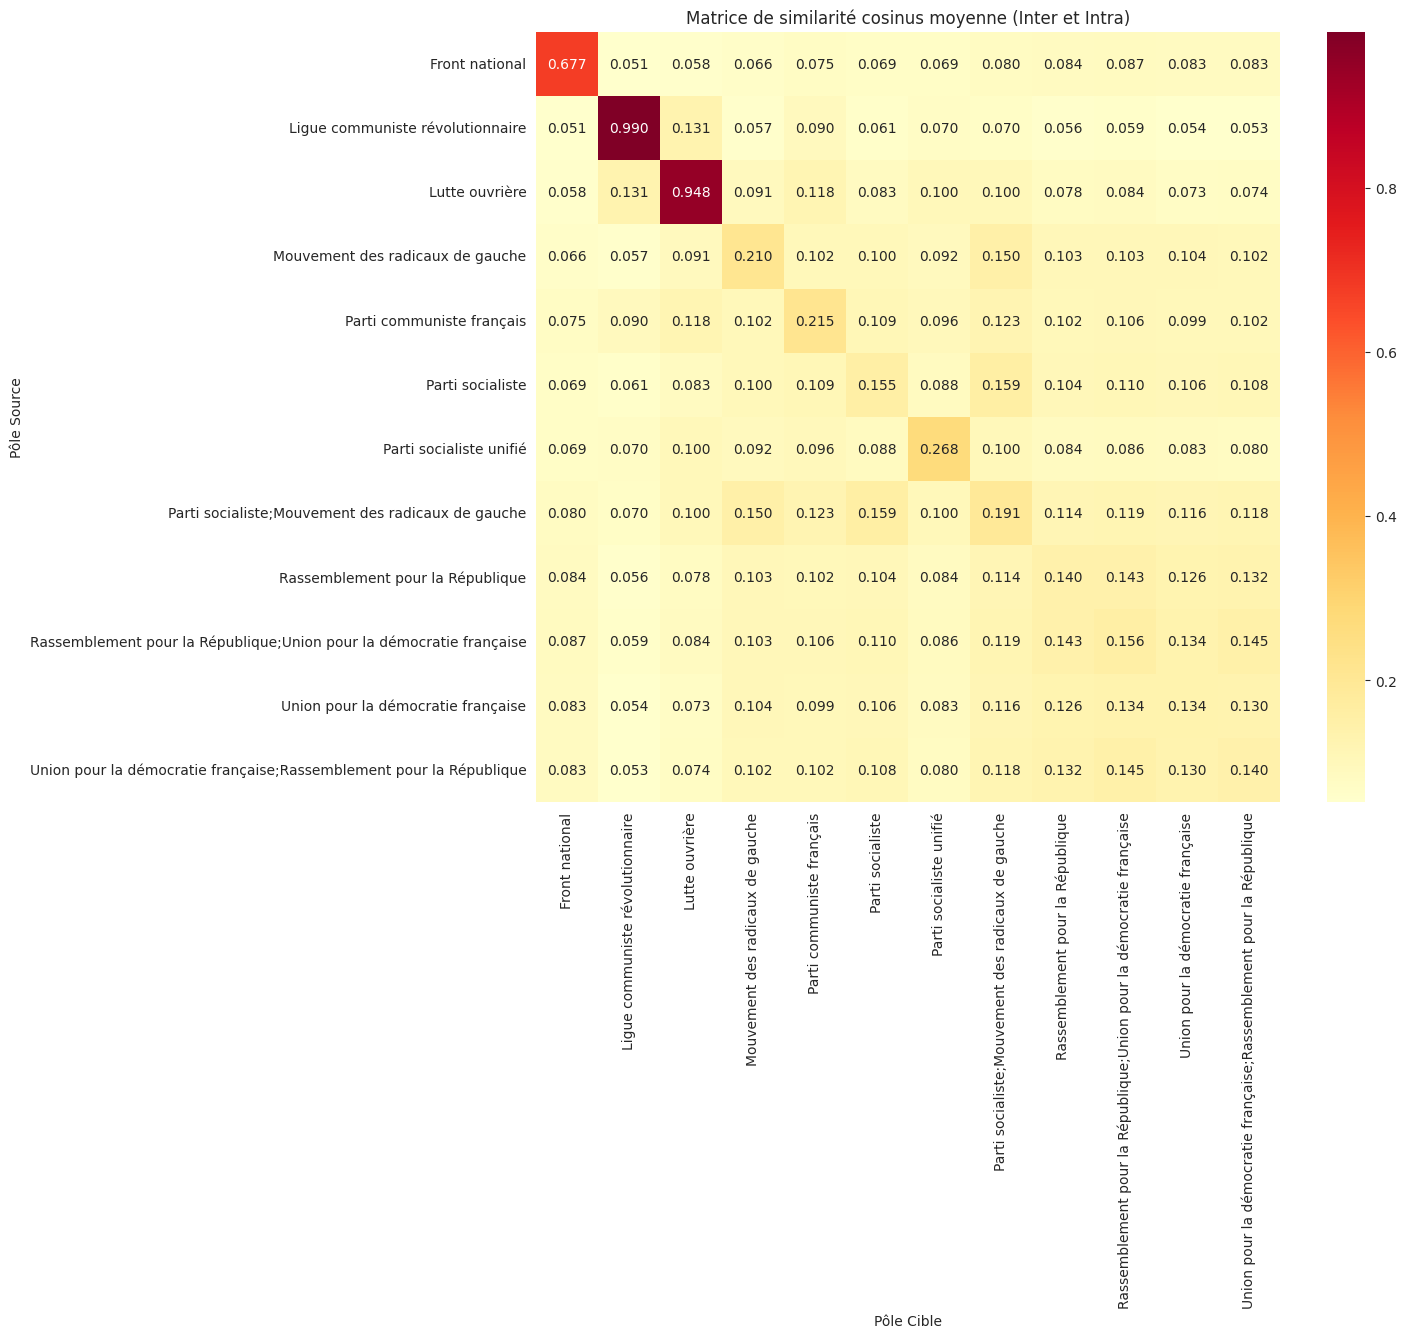

In [51]:
# Pivoter les données pour créer une matrice
matrix_inter = df_sim_final.pivot(index='Pôle Source', columns='Pôle Cible', values='Similarité Moyenne')

plt.figure(figsize=(12, 10))
sns.heatmap(matrix_inter, annot=True, fmt=".3f", cmap="YlOrRd")
plt.title("Matrice de similarité cosinus moyenne (Inter et Intra)")
plt.show()

## 4.2 Projection



A verif on travaille bien avec df without bi-categories

In [ ]:
############################""  Visualizing the ideological space of the manifestos using 2D projection (t-SNE or UMAP)###################
#  Points are colored by party/support (titulaire-soutien)


#Get probabilities from the logistic regression model
probas = best_model.predict_proba(df_final_sans_cat_mixte['clean_text_filtered'].astype(str))  # shape (num_texts, n_classes)

# Convert probabilities to a DataFrame for easier handling
proba_df = pd.DataFrame(probas, columns=best_model.classes_)
df_final_sans_cat_mixte = df_final_sans_cat_mixte.reset_index(drop=True)
df_final_sans_cat_mixte = pd.concat([df_final_sans_cat_mixte, proba_df], axis=1)

# Compute 2D projection (t-SNE) 
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(proba_df.values)  # Use probabilities as features
df_final_sans_cat_mixte['tsne_1'] = tsne_results[:, 0]
df_final_sans_cat_mixte['tsne_2'] = tsne_results[:, 1]

# Color palette
# ------------------- Custom color palette -------------------
custom_palette = {
    'Parti socialiste': '#E400D0',               # Pink
    'Parti socialiste unifié': '#FF66CC',        # Light Pink
    'Mouvement des radicaux de gauche': '#FF99FF', # Very light pink / lavender
    'Rassemblement pour la République': '#0055A4',  # Dark Blue
    'Union pour la démocratie française': '#00BFFF', # Light Blue
    'Parti communiste français': '#FF0000',     # Red
    'Ligue communiste révolutionnaire': '#CC0000', # Dark Red
    'Lutte ouvrière': '#00FF00',                # Green
    'Front national': '#000033',                # Dark Navy
    'Ecologiste': '#33CC33',                     # Dark Green
}


#  Scatterplot with improved visuals
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")  # Clean background for readability

plot = sns.scatterplot(
    data=df_final_sans_cat_mixte, 
    x='tsne_1',           # First 2D coordinate from projection
    y='tsne_2',           # Second 2D coordinate from projection
    hue='titulaire-soutien', 
    palette=custom_palette,  # Use custom colors
    style='titulaire-soutien',  # Different shapes per party for clarity
    alpha=0.8, 
    edgecolor='w', 
    s=60  # Point size
)

# Final touches
plt.title("Ideological Space of 1981 Legislative Manifestos (t-SNE Projection)", fontsize=15)
plt.legend(
    bbox_to_anchor=(1.02, 1), 
    loc='upper left', 
    borderaxespad=0, 
    title="Party / Support"
)
plt.tight_layout()
plt.show()


Number of RPR candidates predicted as PS: 3


,text_content,titulaire-soutien,parti_geographique
647,Sciences Po / fonds CEVIPOF\nElections Législa...,Rassemblement pour la République,Parti socialiste
857,Sciences Po / fonds CEVIPOF\nELECTIONS LEGISLA...,Rassemblement pour la République,Parti socialiste
1462,Sciences Po / fonds CEVIPOF\nELECTIONS LEGISLA...,Rassemblement pour la République,Parti socialiste


Nous calculons ensuite les moyennes de similarité intra-parti et inter-partis pour mesurer:
La Cohésion (Intra) : Est-ce que les candidats d'un même parti parlent tous d'une seule voix (discipline de camp) ou sont-ils dispersés ?
La Porosité (Inter) : À quel point le discours d'un bloc "déborde" sur l'autre ?

/tmp/ipykernel_216270/2072668758.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


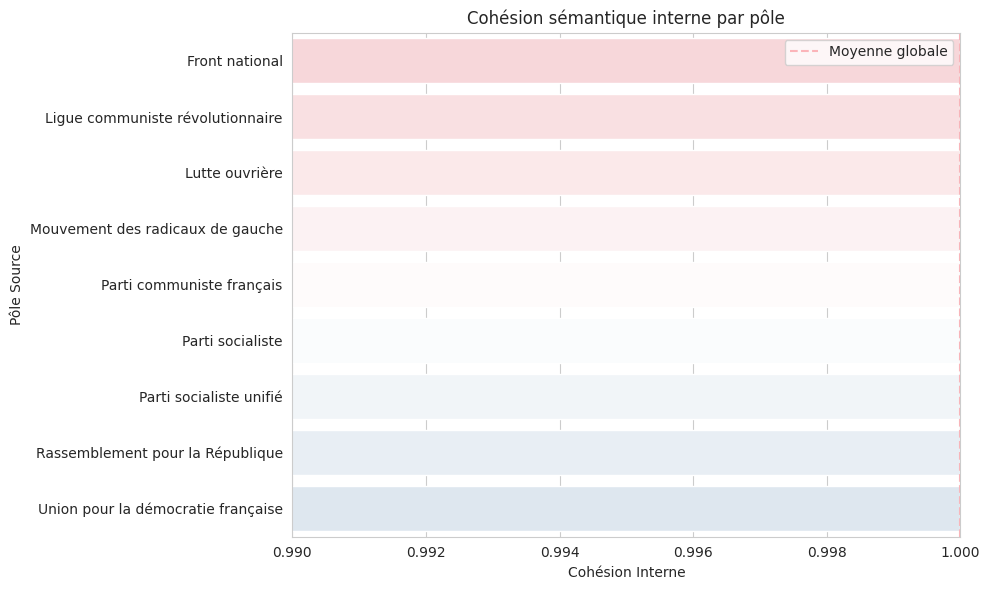

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

############ Compute intra-party cohesion from cosine distance matrix ###########

# Cohésion = 1 - distance (si distance cosinus)
intra_cohesion = 1 - np.diag(dist_df_cos.values)

df_intra = pd.DataFrame({
    "Pôle Source": dist_df_cos.index,
    "Cohésion Interne": intra_cohesion
}).sort_values("Cohésion Interne", ascending=False)

############ Define same pastel gradient as heatmap ##############################

colors = ["#fbb4b9", "white", "#b3cde3"]
cmap = LinearSegmentedColormap.from_list("pastel_gradient", colors)

############ Plot ################################################################

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_intra,
    x="Cohésion Interne",
    y="Pôle Source",
    palette=[cmap(0.2 + 0.6*i/len(df_intra)) for i in range(len(df_intra))]
)

plt.title("Cohésion sémantique interne par pôle")
plt.xlim(df_intra["Cohésion Interne"].min() - 0.01, 1.0)

# Ligne moyenne
plt.axvline(
    df_intra["Cohésion Interne"].mean(),
    color='#fbb4b9',
    linestyle='--',
    label='Moyenne globale'
)

plt.legend()
plt.tight_layout()
plt.show()


Identifier les Outliers (Erreurs à forte confiance)
L'idée est de comparer la prédiction du modèle avec la réalité. Un "outlier" ici est un texte classé "A" par le modèle avec une probabilité de 90%, alors qu'il appartient au parti "B".

In [45]:
from sklearn.neighbors import KNeighborsClassifier

# Coordinates for K-NN
coords = df_final_sans_cat_mixte[['tsne_1', 'tsne_2']].values
labels = df_final_sans_cat_mixte['titulaire-soutien'].values

# K-NN
k = 10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(coords, labels)

# Predict “geographical party”
df_final_sans_cat_mixte['parti_geographique'] = knn.predict(coords)

# Identify outliers
outliers_geo = df_final_sans_cat_mixte[
    df_final_sans_cat_mixte['titulaire-soutien'] != df_final_sans_cat_mixte['parti_geographique']
]

# Example: RPR points classified like PS
rpr_chez_ps = outliers_geo[
    (outliers_geo['titulaire-soutien'] == 'Rassemblement pour la République') & 
    (outliers_geo['parti_geographique'] == 'Parti socialiste')
]

print(f"Number of RPR candidates predicted as PS: {len(rpr_chez_ps)}")
display(rpr_chez_ps[['text_content', 'titulaire-soutien', 'parti_geographique']].head())


Number of RPR candidates predicted as PS: 3


,text_content,titulaire-soutien,parti_geographique
647,Sciences Po / fonds CEVIPOF\nElections Législa...,Rassemblement pour la République,Parti socialiste
857,Sciences Po / fonds CEVIPOF\nELECTIONS LEGISLA...,Rassemblement pour la République,Parti socialiste
1462,Sciences Po / fonds CEVIPOF\nELECTIONS LEGISLA...,Rassemblement pour la République,Parti socialiste


Distance au centre du Cluster (Le "Cœur" idéologique)
Pour chaque parti, on calcule son point moyen (centroïde) et on mesure qui s'en éloigne.

Pourquoi c'est puissant pour ton analyse ?
Le Centre : Tu identifies le "manifeste type" du PS ou du RPR en 1981 (celui qui a la distance_au_centre la plus faible).

Les Outliers : Si un manifeste de droite est classé à gauche avec 90% de confiance, c'est peut-être une erreur d'archivage ou un candidat qui a utilisé une rhétorique très spécifique (ex: gaullisme social).

PCA vs t-SNE : Le PCA te montrera peut-être un axe Gauche/Droite très clair (Axe 1), alors que le t-SNE te montrera si les "Radicaux de Gauche" sont vraiment un groupe à part ou s'ils sont noyés dans le PS.



In [46]:
from scipy.spatial.distance import cdist
import numpy as np

# 1️⃣ Extraire les features du pipeline logistique
# On peut utiliser les probabilités comme “représentation” ou le TF-IDF
X = best_model.named_steps['tfidf'].transform(df_final['clean_text_filtered']).toarray()

# 2️⃣ Créer une colonne pour stocker la distance au centre
df_final['distance_au_centre'] = np.nan

# 3️⃣ Calculer le centre de chaque parti et la distance cosinus
for parti in df_final['titulaire-soutien'].unique():
    # Sélectionner les vecteurs du parti
    mask = df_final['titulaire-soutien'] == parti
    points_parti = X[mask]
    
    # Calculer le centre (moyenne des vecteurs)
    centre = points_parti.mean(axis=0).reshape(1, -1)
    
    # Distance de chaque point au centre
    distances = cdist(points_parti, centre, metric='cosine').flatten()
    
    # Stocker dans le DataFrame
    df_final.loc[mask, 'distance_au_centre'] = distances

# ✅ Les manifestes avec la plus petite distance sont les "échantillons purs"
# ✅ Ceux avec la plus grande distance sont les "marginaux"


1. Identifier les points "égarés" (Outliers de position)
Pour identifier mathématiquement un point rouge perdu chez les verts, on utilise les coordonnées t-SNE. On définit une zone de "contamination" ou on cherche les points dont les voisins les plus proches appartiennent à un autre parti.

1. L'Outlier de Classification (Erreur de "Logique")
C'est ce que nous avons fait avec le Random Forest et les probabilités (confiance > 0.8).

Définition : Le modèle prédit "Parti A" avec une certitude absolue, mais l'étiquette réelle est "Parti B".

Interprétation : C'est une anomalie textuelle. Soit le candidat a "trahi" son camp en utilisant le vocabulaire de l'adversaire, soit il y a une erreur d'étiquetage dans vos données.

Utilité : Identifier les discours de rupture ou les candidats atypiques (ex: un candidat de droite très social).

2. L'Outlier de Distance (Anomalie de "Position")
C'est ce que nous avons fait avec le calcul de la distance_au_centre (ou distance au centroïde).

Définition : Le texte est très éloigné du "cœur" statistique de son propre parti.

Interprétation : C'est une anomalie de style ou de thématique. Le texte ne ressemble à aucun autre dans son camp, sans pour autant ressembler forcément à l'adversaire. Il est simplement "marginal".

Utilité : Identifier les manifestes qui traitent de sujets très spécifiques, locaux, ou dont le ton est unique.

Comment combiner les deux pour une analyse "Expert" ?
Pour finaliser votre identification, vous pouvez croiser ces deux critères pour trouver les "Vrais Dissidents" de 1981 : ceux qui sont loin de leur centre ET que le modèle classe ailleurs.

Python
# 1. On combine les critères
# On cherche ceux qui sont loin de leur centre ET mal classés
dissidents = df_final[
    (df_final['distance_au_centre_global'] > df_final['distance_au_centre_global'].quantile(0.75)) & 
    (df_final['prediction'] != df_final['pole_politique'])
]

print(f"Nombre de 'dissidents sémantiques' identifiés : {len(dissidents)}")

# 2. Visualisation des dissidents sur le PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='pca_1', y='pca_2', hue='pole_politique', alpha=0.3)
sns.scatterplot(data=dissidents, x='pca_1', y='pca_2', color='black', marker='o', s=100, label='Dissidents')
plt.title("Localisation des dissidents sémantiques (Loin du centre + Mal classés)")
plt.show()
Ce qu'il vous reste à faire (en application) :
Si vous voulez vraiment boucler l'identification, il serait intéressant de regarder la "Similarité Cosinus par rapport au Centroïde adverse".

Si un candidat RPR a une similarité cosinus plus élevée avec le centroïde PS qu'avec son propre centroïde RPR, alors vous tenez mathématiquement un cas de "mimétisme politique".